In [1]:
pip install deepxde --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.4 MB/s eta 0:00:00


In [2]:
import os
# STEP 1: Set backend BEFORE importing deepxde
os.environ["DDE_BACKEND"] = "tensorflow"

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [3]:
# STEP 2: Robust ADR Solver implementation to avoid "function not subscriptable" errors
def solve_ADR(xmin, xmax, tmin, tmax, D_fn, advection_fn, reaction_fn, v_data, nx, nt):
    x = np.linspace(xmin, xmax, nx)
    t = np.linspace(tmin, tmax, nt)
    dx = x[1] - x[0]

    # D_fn and others might be passed as lambdas
    D = D_fn(x)[0]

    def system(u, t_val):
        # Central difference for Diffusion (d2u/dx2)
        d2u_dx2 = (np.roll(u, -1) - 2*u + np.roll(u, 1)) / (dx**2)

        # Dirichlet Boundary Conditions (u=0 at boundaries)
        d2u_dx2[0] = 0
        d2u_dx2[-1] = 0

        # Determine current source term v at this time step
        t_idx = int(t_val / (tmax - tmin) * (nt - 1))
        t_idx = min(t_idx, nt - 1)

        # Reaction: -0.01 * u^2 + v
        # We index v_data which is now passed as a pre-computed array
        v_current = v_data[t_idx] if v_data.ndim > 1 else v_data

        du_dt = D * d2u_dx2 - reaction_fn(u) + v_current
        return du_dt

    u0 = np.zeros(nx)
    sol = odeint(system, u0, t)
    return x, t, sol


In [4]:
# --- PDE Setup ---
def pde(x, y, v):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return dy_t - D * dy_xx + k * y**2 - v


def func_zero(x):
    return 0

def boundary_check(x, on_boundary):
    return on_boundary

def initial_check(x, on_initial):
    return on_initial

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


bc = dde.icbc.DirichletBC(geomtime, func_zero, boundary_check)
ic = dde.icbc.IC(geomtime, func_zero, initial_check)

pde_data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=200,
    num_boundary=40,
    num_initial=20,
    num_test=500,
)

Compiling model...
'compile' took 0.003574 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.04e+00, 3.94e+00, 7.52e-01]    [2.37e+00, 2.96e+00, 6.37e-01]    []  
1000      [1.78e-01, 5.42e-02, 1.55e-02]    [1.97e-01, 5.18e-02, 1.61e-02]    []  
2000      [1.09e-01, 5.69e-02, 1.54e-02]    [1.13e-01, 5.14e-02, 1.37e-02]    []  
3000      [7.21e-02, 4.51e-02, 1.15e-02]    [8.07e-02, 4.45e-02, 1.09e-02]    []  
4000      [5.96e-02, 3.84e-02, 1.34e-02]    [5.11e-02, 3.66e-02, 1.07e-02]    []  
5000      [3.25e-02, 3.00e-02, 5.98e-03]    [2.87e-02, 3.05e-02, 7.12e-03]    []  
6000      [2.54e-02, 2.36e-02, 7.69e-03]    [2.34e-02, 2.63e-02, 8.89e-03]    []  
7000      [3.25e-02, 2.24e-02, 9.18e-03]    [2.21e-02, 2.05e-02, 7.84e-03]    []  
8000      [2.61e-02, 1.59e-02, 6.49e-03]    [2.12e-02, 1.90e-02, 6.90e-03]    []  
9000      [2.24e-02, 1.03e-02, 4.09e-03]    [2.04e-02, 1.19e-02, 5.33e-03]    []  
10000     [1.98

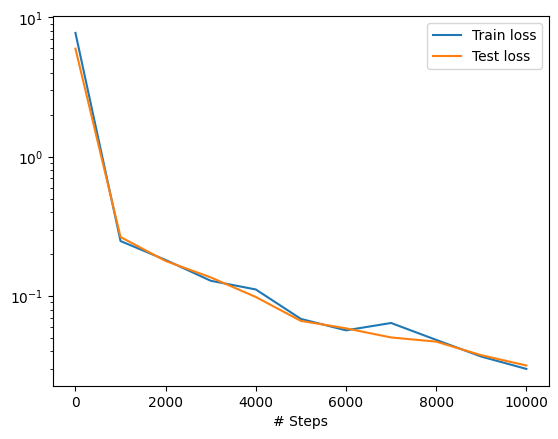

In [7]:
# --- Function space & Operator Data ---
func_space = dde.data.GRF(length_scale=0.2)
eval_pts = np.linspace(0, 1, num=50)[:, None]
data = dde.data.PDEOperatorCartesianProd(
    pde_data, func_space, eval_pts, 1000, function_variables=[0], num_test=100, batch_size=50
)

# --- DeepONet Architecture ---
net = dde.nn.DeepONetCartesianProd(
    [50, 128, 128, 128], # Branch
    [2, 128, 128, 128],  # Trunk (x, t)
    "tanh",
    "Glorot normal",
)

model = dde.Model(data, net)
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(iterations=10000) # Reduced for testing
dde.utils.plot_loss_history(losshistory)


L2 Relative Error: 0.532308263540451


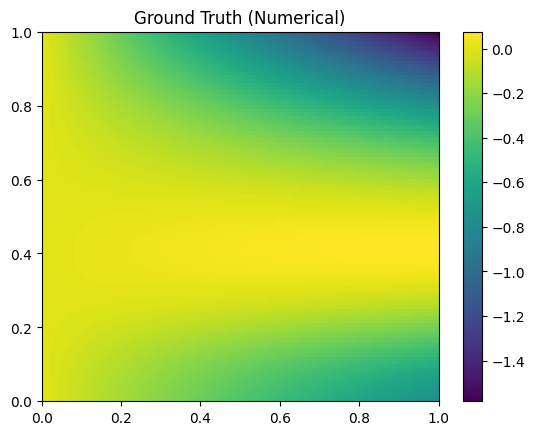

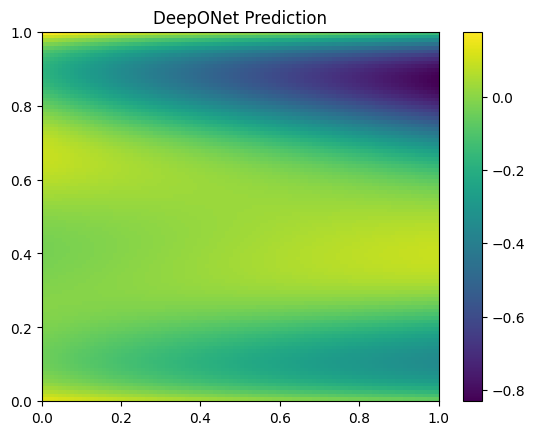

In [8]:
# --- Prediction and Validation ---
func_feats = func_space.random(1)
xs = np.linspace(0, 1, num=100)[:, None]
v_samples = func_space.eval_batch(func_feats, xs)[0]

# Prepare numerical source term for the solver (nt, nx)
v_numeric = np.tile(v_samples, (100, 1))

# Corrected 10-argument call
x, t, u_true = solve_ADR(
    0, 1, 0, 1,
    lambda x: 0.01 * np.ones_like(x),
    lambda x: np.zeros_like(x),
    lambda u: 0.01 * u**2,
    v_numeric,
    100,
    100
)

u_true = u_true.T # Transpose to match (nx, nt)
plt.figure()
plt.title("Ground Truth (Numerical)")
plt.imshow(u_true, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

# Model Prediction
v_branch = func_space.eval_batch(func_feats, np.linspace(0, 1, num=50)[:, None])
xv, tv = np.meshgrid(x, t)
x_trunk = np.vstack((np.ravel(xv), np.ravel(tv))).T
u_pred = model.predict((v_branch, x_trunk))
u_pred = u_pred.reshape((100, 100))

print("L2 Relative Error:", dde.metrics.l2_relative_error(u_true.T, u_pred))

plt.figure()
plt.title("DeepONet Prediction")
plt.imshow(u_pred.T, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()
plt.show()